In [1]:
from sklearn.model_selection import cross_val_score, GroupKFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso
import lightgbm as lgb
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
import shap
import pickle
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.colors as mcolors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import gridspec



In [2]:
black = '#515265'
red = '#DD706E'
yellow = '#FAAF3A'
blue = '#3A93C2'

In [3]:
file_path = "../Exp_2_Dataset_feature_engineering/Summary_and_dataset/refined_dataset.csv"

data = pd.read_csv(file_path)
train = data[data['Type'] == 'Train']
test = data[data['Type'] == 'Test']
lab = data[data['Type'] == 'Lab']

In [4]:
overlapping_values = set(train['Drug-solvent system']).intersection(test['Drug-solvent system'])
overlapping_values

set()

In [5]:
def data_processing (dataset):

    X = dataset.drop(['Type', 'Drug', 'Solvent_1', 'Solvent_2', 'Drug-solvent system', 'LogS', 'Class', 'Solubility (g/100g)'], axis = 1)
    Y = dataset['LogS']
    G = dataset['Drug-solvent system']

    return X, Y, G

In [6]:
X_train, Y_train, G_train = data_processing(train)
X_test, Y_test, G_test = data_processing(test)
X_lab, Y_lab, G_lab = data_processing(lab)

# Hyperparameter screening

In [7]:
pickle_file_path = '../Exp_3_model_training_optimization/Original/Results/BSCV_results.pkl'

In [8]:
with open(pickle_file_path, 'rb') as handle:
    results = pickle.load(handle)

Trying to unpickle estimator DecisionTreeRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator MLPRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LinearRegression from version 1.1.3 when using version 1.1.2. This might lead to breaking code or 

In [9]:
results

{'DT': {'best_estimator': DecisionTreeRegressor(max_depth=20, max_features='auto', min_samples_leaf=8,
                        min_samples_split=0.01, random_state=0,
                        splitter='random'),
  'best_params': OrderedDict([('max_depth', 20),
               ('max_features', 'auto'),
               ('min_samples_leaf', 8),
               ('min_samples_split', 0.01),
               ('splitter', 'random')]),
  'best_score': -0.4700293292782832},
 'RF': {'best_estimator': RandomForestRegressor(bootstrap=False, max_depth=18, max_features='sqrt',
                        min_samples_split=0.01, n_estimators=354, n_jobs=6,
                        random_state=0),
  'best_params': OrderedDict([('bootstrap', False),
               ('max_depth', 18),
               ('max_features', 'sqrt'),
               ('min_samples_leaf', 1),
               ('min_samples_split', 0.01),
               ('n_estimators', 354)]),
  'best_score': -0.43535884700904787},
 'XGB': {'best_estimator': XG

# Model evaluation using the literature test set

In [10]:
best_model = results['LightGBM']['best_estimator']

In [11]:
literature_X_scaled = pd.concat([X_train, X_test], ignore_index=True)
literature_Y = pd.concat([Y_train, Y_test], ignore_index=True)

In [12]:
literature_X_scaled

,Solvent_mass_fraction,Temperature (K),Drug_Melting_temp (K),Drug_Maccs_8,Drug_Maccs_15,Drug_Maccs_17,Drug_Maccs_19,Drug_Maccs_21,Drug_Maccs_23,Drug_Maccs_24,...,Solvent_2_EState_VSA2,Solvent_2_EState_VSA3,Solvent_2_EState_VSA4,Solvent_2_EState_VSA5,Solvent_2_EState_VSA6,Solvent_2_EState_VSA9,Solvent_2_VSA_EState5,Solvent_2_NOCount,Solvent_2_NumAliphaticCarbocycles,Solvent_2_NumAliphaticRings
0,-1.462508,-1.594466,0.035448,-0.098286,-0.090932,-0.067312,-0.257313,-0.093197,-0.213749,-0.322175,...,-1.844157,2.395496,1.604105,-0.381472,-0.545118,0.960140,-0.052602,0.078498,-0.092698,-0.130403
1,0.232488,0.411506,0.311461,-0.098286,-0.090932,-0.067312,-0.257313,-0.093197,-0.213749,-0.322175,...,0.629695,2.395496,3.509625,0.672117,-0.545118,-0.612628,-2.559062,2.749726,-0.092698,-0.130403
2,0.571555,0.077177,0.311461,-0.098286,-0.090932,-0.067312,-0.257313,-0.093197,-0.213749,-0.322175,...,0.629695,2.395496,3.509625,0.672117,-0.545118,-0.612628,-2.559062,2.749726,-0.092698,-0.130403
3,0.571555,-0.257152,0.311461,-0.098286,-0.090932,-0.067312,-0.257313,-0.093197,-0.213749,-0.322175,...,0.629695,2.395496,3.509625,0.672117,-0.545118,-0.612628,-2.559062,2.749726,-0.092698,-0.130403
4,0.571555,-0.591480,0.311461,-0.098286,-0.090932,-0.067312,-0.257313,-0.093197,-0.213749,-0.322175,...,0.629695,2.395496,3.509625,0.672117,-0.545118,-0.612628,-2.559062,2.749726,-0.092698,-0.130403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27252,0.575284,-0.925809,-1.030270,-0.098286,-0.090932,-0.067312,3.886316,-0.093197,-0.213749,-0.322175,...,0.425334,-0.244963,-0.301415,-0.381472,-0.545118,-0.612628,-0.052602,0.078498,-0.092698,-0.130403
27253,0.575284,0.745834,-1.030270,-0.098286,-0.090932,-0.067312,3.886316,-0.093197,-0.213749,-0.322175,...,0.425334,-0.244963,-0.301415,-0.381472,-0.545118,-0.612628,-0.052602,0.078498,-0.092698,-0.130403
27254,0.575284,1.080163,-1.030270,-0.098286,-0.090932,-0.067312,3.886316,-0.093197,-0.213749,-0.322175,...,0.425334,-0.244963,-0.301415,-0.381472,-0.545118,-0.612628,-0.052602,0.078498,-0.092698,-0.130403
27255,0.575284,1.414491,-1.030270,-0.098286,-0.090932,-0.067312,3.886316,-0.093197,-0.213749,-0.322175,...,0.425334,-0.244963,-0.301415,-0.381472,-0.545118,-0.612628,-0.052602,0.078498,-0.092698,-0.130403


In [13]:
best_model.fit(literature_X_scaled, literature_Y)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


LGBMRegressor(bagging_fraction=0.5, feature_fraction=0.5,
              learning_rate=0.040803979776290245, max_depth=8,
              min_child_samples=100, n_estimators=674, n_jobs=6, num_leaves=400,
              random_state=0)

In [14]:
with open('LightGBM.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [15]:
with open('LightGBM.pkl', 'rb') as file:
    best_model = pickle.load(file)


In [16]:
Y_pred = best_model.predict(X_lab)

In [17]:
summary = pd.DataFrame()

summary['Y_pred'] = Y_pred
summary['Y_exp'] = Y_lab.values
summary['Drug'] = lab['Drug'].values
summary['Temperature'] = lab['Temperature (K)'].values
summary['Solvent_mass_fraction'] = lab['Solvent_mass_fraction'].values
summary

,Y_pred,Y_exp,Drug,Temperature,Solvent_mass_fraction
0,-0.494261,-0.732561,3-Indolepropionic acid,-0.257152,-1.123780
1,0.667298,1.242254,Aspirin,0.745834,-0.106579
2,0.085625,0.407800,Aspirin,0.745834,-1.123780
3,0.748155,1.297876,Aspirin,-0.257152,0.910622
4,0.456576,1.001880,Aspirin,-0.257152,-0.106579
5,-0.100549,0.051018,Aspirin,-0.257152,-1.123780
6,0.606534,1.313949,3-Indolepropionic acid,0.745834,0.910622
7,0.396504,0.946698,3-Indolepropionic acid,0.745834,-0.106579
8,-0.239407,-0.285845,3-Indolepropionic acid,0.745834,-1.123780
9,0.329305,1.143119,3-Indolepropionic acid,-0.257152,0.910622


In [18]:
drug_order = ['Celecoxib', 'Acetaminophen', '3-Indolepropionic acid', 'Aspirin']
summary['Drug'] = pd.Categorical(summary['Drug'], categories=drug_order, ordered=True)

summary_sorted = summary.sort_values(by=['Drug', 'Temperature', 'Solvent_mass_fraction'])

summary_sorted = summary_sorted.reset_index(drop = True)
summary_sorted

,Y_pred,Y_exp,Drug,Temperature,Solvent_mass_fraction
0,-0.327642,-3.061188,Celecoxib,-0.257152,-1.123780
1,0.528854,-0.351141,Celecoxib,-0.257152,-0.106579
2,0.875122,0.685046,Celecoxib,-0.257152,0.910622
3,0.032303,-2.505811,Celecoxib,0.745834,-1.123780
4,0.755374,0.011534,Celecoxib,0.745834,-0.106579
5,1.047485,0.933291,Celecoxib,0.745834,0.910622
6,-0.081674,0.568126,Acetaminophen,-0.257152,-1.123780
7,0.929562,1.165377,Acetaminophen,-0.257152,-0.106579
8,1.086698,1.280612,Acetaminophen,-0.257152,0.910622
9,0.217941,0.830016,Acetaminophen,0.745834,-1.123780


In [19]:
file_path = "../Exp_1_Raw_Dataset/Raw_dataset_dataset_20240130.csv"
original_data = pd.read_csv(file_path)

lab_X = original_data[original_data['Type'] == 'Lab']
literature_X = original_data[original_data['Type'] != 'Lab']

In [20]:
cols_of_interest = ['Drug','Drug_ExactMolWt', 'Drug_Melting_temp (K)']

In [21]:
experiment_STD = [0.026547199, 0.007765518, 0.00609362, 0.011489668, 0.009077589, 0.004943748,
                 0.009819746, 0.007260406, 0.020924193, 0.008093572, 0.005818861, 0.009665102,
                0.016553364, 0.008737235, 0.005338153, 0.021981287, 0.023570222, 0.012345814,
                 0.004954186, 0.007637141, 0.003202658, 0.012285287, 0.0108218, 0.005967770]

In [22]:
plot = lab_X[['Drug','Solvent_mass_fraction','Temperature (K)','LogS']]
plot['LogS_SD'] = experiment_STD
plot['Y_pred'] = summary_sorted['Y_pred'].values

plot['AE'] = abs(plot['LogS'] - plot['Y_pred'])
plot


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Drug,Solvent_mass_fraction,Temperature (K),LogS,LogS_SD,Y_pred,AE
27257,Celecoxib,0.2,298.15,-3.061188,0.026547,-0.327642,2.733546
27258,Celecoxib,0.5,298.15,-0.351141,0.007766,0.528854,0.879995
27259,Celecoxib,0.8,298.15,0.685046,0.006094,0.875122,0.190076
27260,Celecoxib,0.2,313.15,-2.505811,0.011490,0.032303,2.538114
27261,Celecoxib,0.5,313.15,0.011534,0.009078,0.755374,0.743840
27262,Celecoxib,0.8,313.15,0.933291,0.004944,1.047485,0.114194
27263,Acetaminophen,0.2,298.15,0.568126,0.009820,-0.081674,0.649801
27264,Acetaminophen,0.5,298.15,1.165377,0.007260,0.929562,0.235815
27265,Acetaminophen,0.8,298.15,1.280612,0.020924,1.086698,0.193914
27266,Acetaminophen,0.2,313.15,0.830016,0.008094,0.217941,0.612074


In [23]:
ACM = plot[plot['Drug'] == 'Acetaminophen']

CXB = plot[plot['Drug'] == 'Celecoxib']

IPA = plot[plot['Drug'] == '3-Indolepropionic acid']

ASA = plot[plot['Drug'] == 'Aspirin']

In [24]:
def exp(df, ax, color, drug, ann):

    unique_temperatures = df['Temperature (K)'].unique()
    fontsize = 12

    width = 0.35  
    x = np.arange(len(df['Solvent_mass_fraction'].unique()))
    
    for i, temp in enumerate(unique_temperatures):
        subset = df[df['Temperature (K)'] == temp]
        
        bar_color = color
        
        ax.bar(x + i * width, subset['LogS'], width=width, label=f'Temperature {temp} K', color=bar_color, edgecolor='black', linewidth=0.5)
        
        if temp == 313.15:
            ax.bar(x + i * width, subset['LogS'], width=width, hatch='///', edgecolor='black', fill=False, linewidth=0)

    for i, temp in enumerate(unique_temperatures):
        subset = df[df['Temperature (K)'] == temp]
        ax.errorbar(x + i * width, subset['LogS'], yerr=subset['LogS_SD'], fmt='none', color='k', capsize=5)

    ax.set_xlabel('Ethanol Fraction')
    ax.set_ylabel('Experimental LogS')
    ax.set_title(drug)  
    ax.set_xticks(x + width * (len(unique_temperatures) - 1) / 2)
    ax.set_xticklabels(df['Solvent_mass_fraction'].unique())
    

    ax.legend().set_visible(False)
    

    ax.axhline(y=0, color='black', linewidth=0.5)
    
    ax.annotate(ann, xy=(0, 1.08), xycoords="axes fraction", va="top", ha="left", fontsize=fontsize)



In [25]:
def metrics(df, ax, color, ann):
    
    
    fontsize = 12
    mae = mean_absolute_error(df['LogS'], df['Y_pred'])
    medae = median_absolute_error(df['LogS'], df['Y_pred'])
    mse = mean_squared_error(df['LogS'], df['Y_pred'])
    rmse = np.sqrt(mse) 

   
    metrics = ['MAE', 'MedAE', 'RMSE', 'MSE']
    values = [mae, medae, rmse, mse]

    
    bars = ax.bar(metrics, values, color = color, edgecolor='black', linewidth=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('Values')
    ax.set_ylim(0, 3.3)
    ax.set_title('')

    
    for bar in bars:
        height = bar.get_height()
        if height >=0:
            ax.text(bar.get_x() + bar.get_width() / 2, height, 
                    f'{height:.2f}', ha='center', va='bottom')
        else:
            ax.text(bar.get_x() + bar.get_width() / 2, 0, 
                    f'{height:.2f}', ha='center', va='bottom')

    ax.annotate(ann, xy=(0, 1.08), xycoords="axes fraction", va="top", ha="left", fontsize=fontsize)



In [26]:
def scatter(df, ax, color, ann):
    fontsize = 12
    
    
    ax.scatter(df['LogS'], df['Y_pred'], color=color)

    
    max_limit = max(df['LogS'].max(), df['Y_pred'].max())
    min_limit = min(df['LogS'].min(), df['Y_pred'].min())
    ax.set_xlim(min_limit-0.2, max_limit+0.2)
    ax.set_ylim(min_limit-0.2, max_limit+0.2)

   
    ax.set_xlabel('Actual LogS')
    ax.set_ylabel('Predicted LogS')
    ax.set_title(df['Drug'].iloc[0])  


    ax.annotate(ann, xy=(0, 1.08), xycoords="axes fraction", va="top", ha="left", fontsize=fontsize)


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


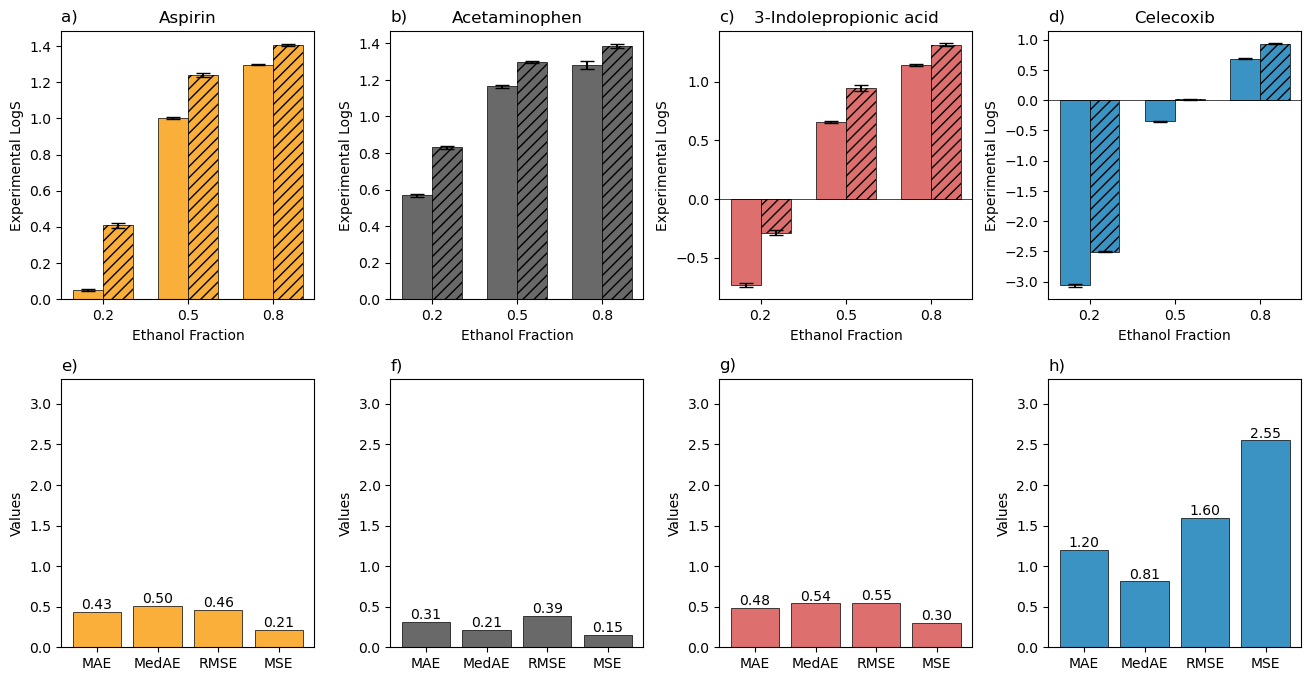

In [27]:
# colors

acm_color = 'dimgray'
ipa_color = red
cxb_color = blue
asa_color = yellow

fig = plt.figure(figsize=(16, 8))
grid = plt.GridSpec(2, 4, wspace=0.3, hspace=0.3)


ax1 = fig.add_subplot(grid[0, 0])
exp(df = ASA, ax = ax1, color = asa_color, ann = 'a)', drug = 'Aspirin')

ax2 = fig.add_subplot(grid[0, 1])
exp(df = ACM, ax = ax2, color = acm_color, ann = 'b)', drug = 'Acetaminophen')


ax3 = fig.add_subplot(grid[0,2])
exp(df = IPA, ax = ax3, color = ipa_color, ann = 'c)', drug = '3-Indolepropionic acid')


ax4 = fig.add_subplot(grid[0, 3])
exp(df = CXB, ax = ax4, color = cxb_color, ann = 'd)', drug = 'Celecoxib')



ax5 = fig.add_subplot(grid[1, 0])
metrics(df = ASA, ax = ax5, color = asa_color, ann = 'e)')

ax6 = fig.add_subplot(grid[1, 1])
metrics(df = ACM, ax = ax6, color = acm_color, ann = 'f)')


ax7 = fig.add_subplot(grid[1,2])
metrics(df = IPA, ax = ax7, color = ipa_color, ann = 'g)')


ax8 = fig.add_subplot(grid[1, 3])
metrics(df = CXB, ax = ax8, color = cxb_color, ann = 'h)')






fig.patch.set(facecolor='none')

plt.tight_layout()

fig.canvas.print_figure('Figure_5_Model_Validation.png', dpi=600)


plt.show()


In [28]:
best_model

LGBMRegressor(bagging_fraction=0.5, feature_fraction=0.5,
              learning_rate=0.040803979776290245, max_depth=8,
              min_child_samples=100, n_estimators=674, n_jobs=6, num_leaves=400,
              random_state=0)

In [29]:
def plot_feature_importance_lgb(model, ax, selected, ann, importance_type='split', top_n=15, filter_drug_features=True):
    fontsize = 12
    

    if importance_type == 'split':
        importances = model.feature_importances_
    elif importance_type == 'gain':
        importances = model.booster_.feature_importance(importance_type='gain')
    feature_names = model.feature_name_
    

    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    

    if filter_drug_features:
        importance_df = importance_df[importance_df['Feature'].str.startswith('Drug_')]

   
    importance_df_top_n = importance_df.head(top_n)

   
    palette_choice = ['lightcoral' if feature in selected else blue for feature in importance_df_top_n['Feature']]
    bars = sns.barplot(x='Importance', y='Feature', data=importance_df_top_n, ax=ax, palette=palette_choice, edgecolor='black')
    
    
    ax.annotate(ann, xy=(0, 1.025), xycoords="axes fraction", va="top", ha="left", fontsize=fontsize)
    ax.set_title("", fontsize=fontsize)
    
    
    ax.set_xlabel("Feature Importance", fontsize=fontsize)
    ax.set_ylabel("", fontsize=fontsize)

    
    ax.tick_params(axis='x', which='major', labelsize=fontsize)
    ax.tick_params(axis='x', which='minor', labelsize=fontsize)
    ax.tick_params(axis='y', which='major', labelsize=fontsize)
    ax.tick_params(axis='y', which='minor', labelsize=fontsize)
    
    return importance_df_top_n



In [30]:
lab_X['Type'] = lab_X['Drug']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
def plot_distribution_with_labels_on_trend(ann, prop, ax, show_legend=False, legend_pos = (-0.08, 1.28), ncol = 2):
    fontsize = 12
    
    
    sns.boxplot(y=literature_X[prop], color='lightcoral', fliersize=1, ax=ax)
    
    
    unique_drugs = ['Aspirin','Acetaminophen', '3-Indolepropionic acid', 'Celecoxib', ]
    colors = [yellow, black, red, blue]
    
    drug_color_map = dict(zip(unique_drugs, colors))
    
    x_positions = np.linspace(-0.0, 0.0, len(unique_drugs))
    
   
    legend_handles = []
    
    
    for idx, drug in enumerate(unique_drugs):
        drug_data = lab_X[lab_X["Drug"] == drug]  
        scatter = ax.scatter([x_positions[idx]] * len(drug_data), drug_data[prop], 
                             color=drug_color_map[drug], label=drug, 
                             alpha=1.0, edgecolor='black', linewidth=0.8, s=180,
                             zorder=10) 
        legend_handles.append(scatter)
    
    ax.set_ylabel('', fontsize=fontsize)
    ax.set_title(prop, fontsize=fontsize)
    
    
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize)
    
    if show_legend:
        ax.legend(handles=legend_handles, title='', loc='upper left', bbox_to_anchor=legend_pos, frameon=False, ncol=ncol, fontsize=fontsize+1)
        
    ax.annotate(ann, xy=(0, 1.05), xycoords="axes fraction", va="top", ha="left", fontsize=fontsize)


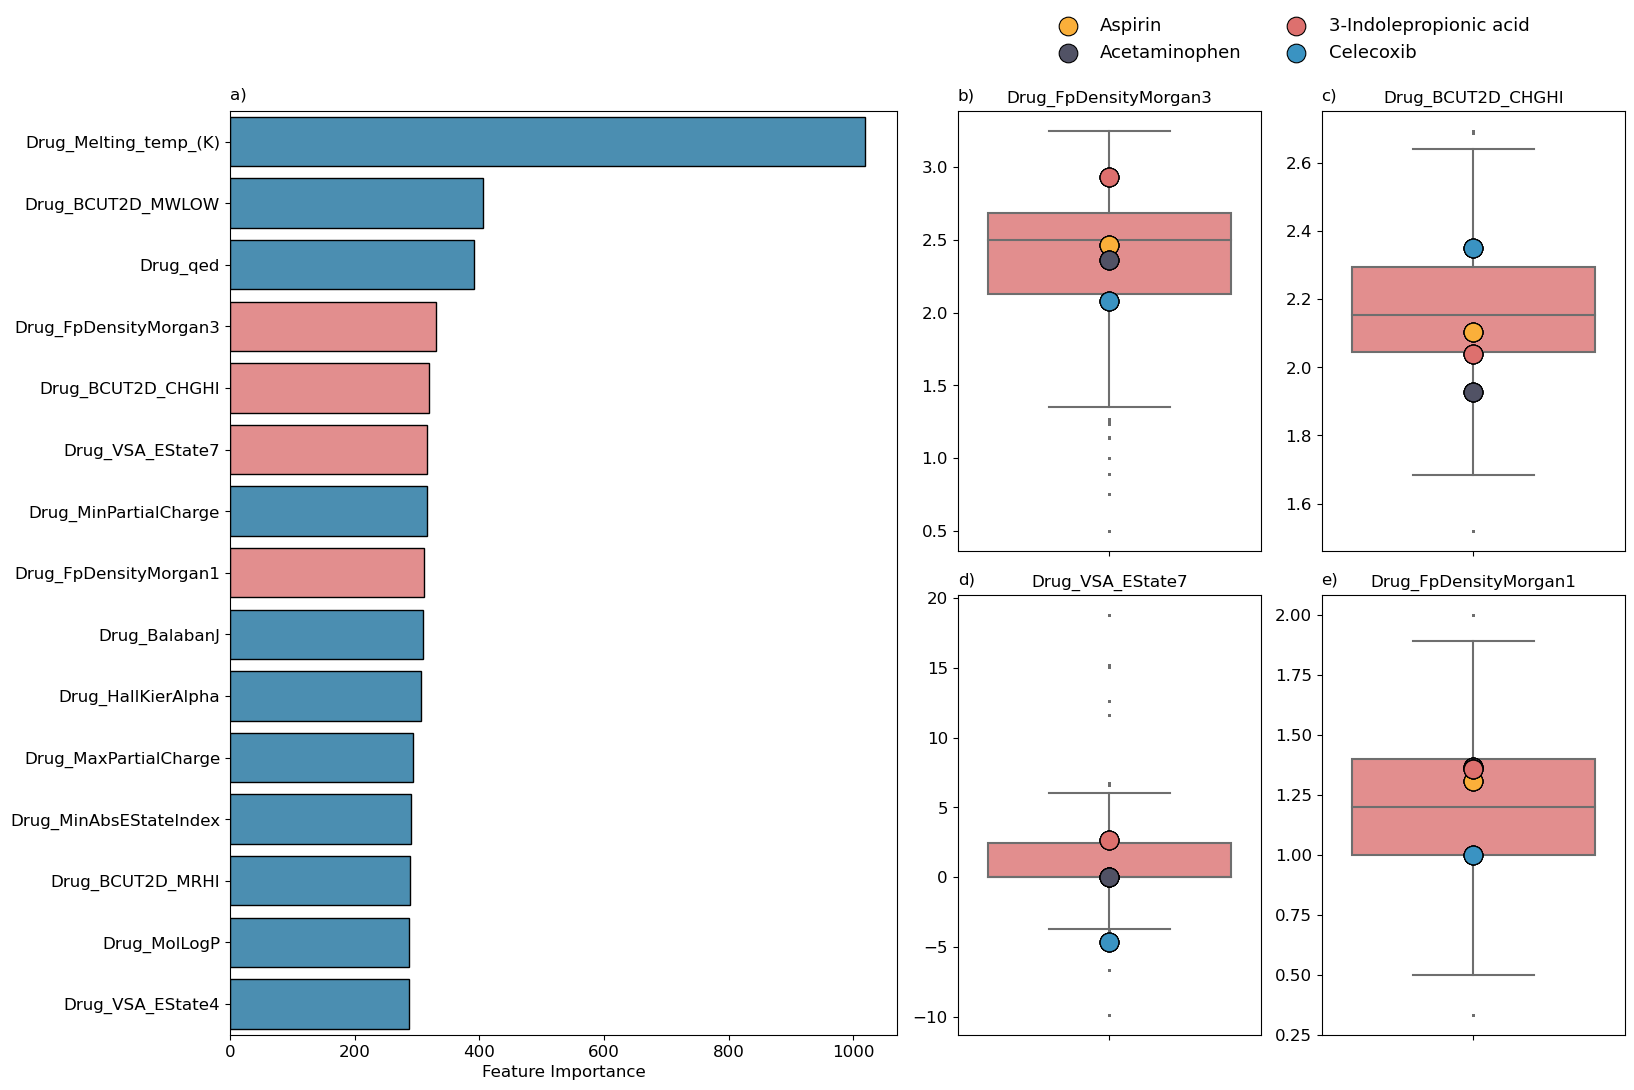

In [32]:
fig = plt.figure(figsize=(18, 12))
grid = gridspec.GridSpec(2, 4, fig, wspace=0.2, hspace=0.1)
selected=['Drug_FpDensityMorgan3','Drug_BCUT2D_CHGHI',  'Drug_VSA_EState7','Drug_FpDensityMorgan1']


ax1 = fig.add_subplot(grid[0:2, 0:2])
important_features = plot_feature_importance_lgb(model=best_model, ax=ax1, selected=selected, ann='a)')


ax2 = fig.add_subplot(grid[0, 2])
plot_distribution_with_labels_on_trend(ann = 'b)',prop='Drug_FpDensityMorgan3', ax=ax2, legend_pos = (0.25, 1.25), ncol = 2, show_legend=True)


ax3 = fig.add_subplot(grid[0, 3])
plot_distribution_with_labels_on_trend(ann = 'c)',prop='Drug_BCUT2D_CHGHI', ax=ax3, show_legend=False)



ax4 = fig.add_subplot(grid[1, 2])
plot_distribution_with_labels_on_trend(ann = 'd)',prop='Drug_VSA_EState7', ax=ax4, show_legend=False)



ax5 = fig.add_subplot(grid[1, 3])
plot_distribution_with_labels_on_trend(ann = 'e)',prop='Drug_FpDensityMorgan1', ax=ax5, show_legend=False)


fig.patch.set(facecolor='none')



fig.canvas.print_figure('Figure_6_Model_Interpretation.png', dpi=600)


plt.show()


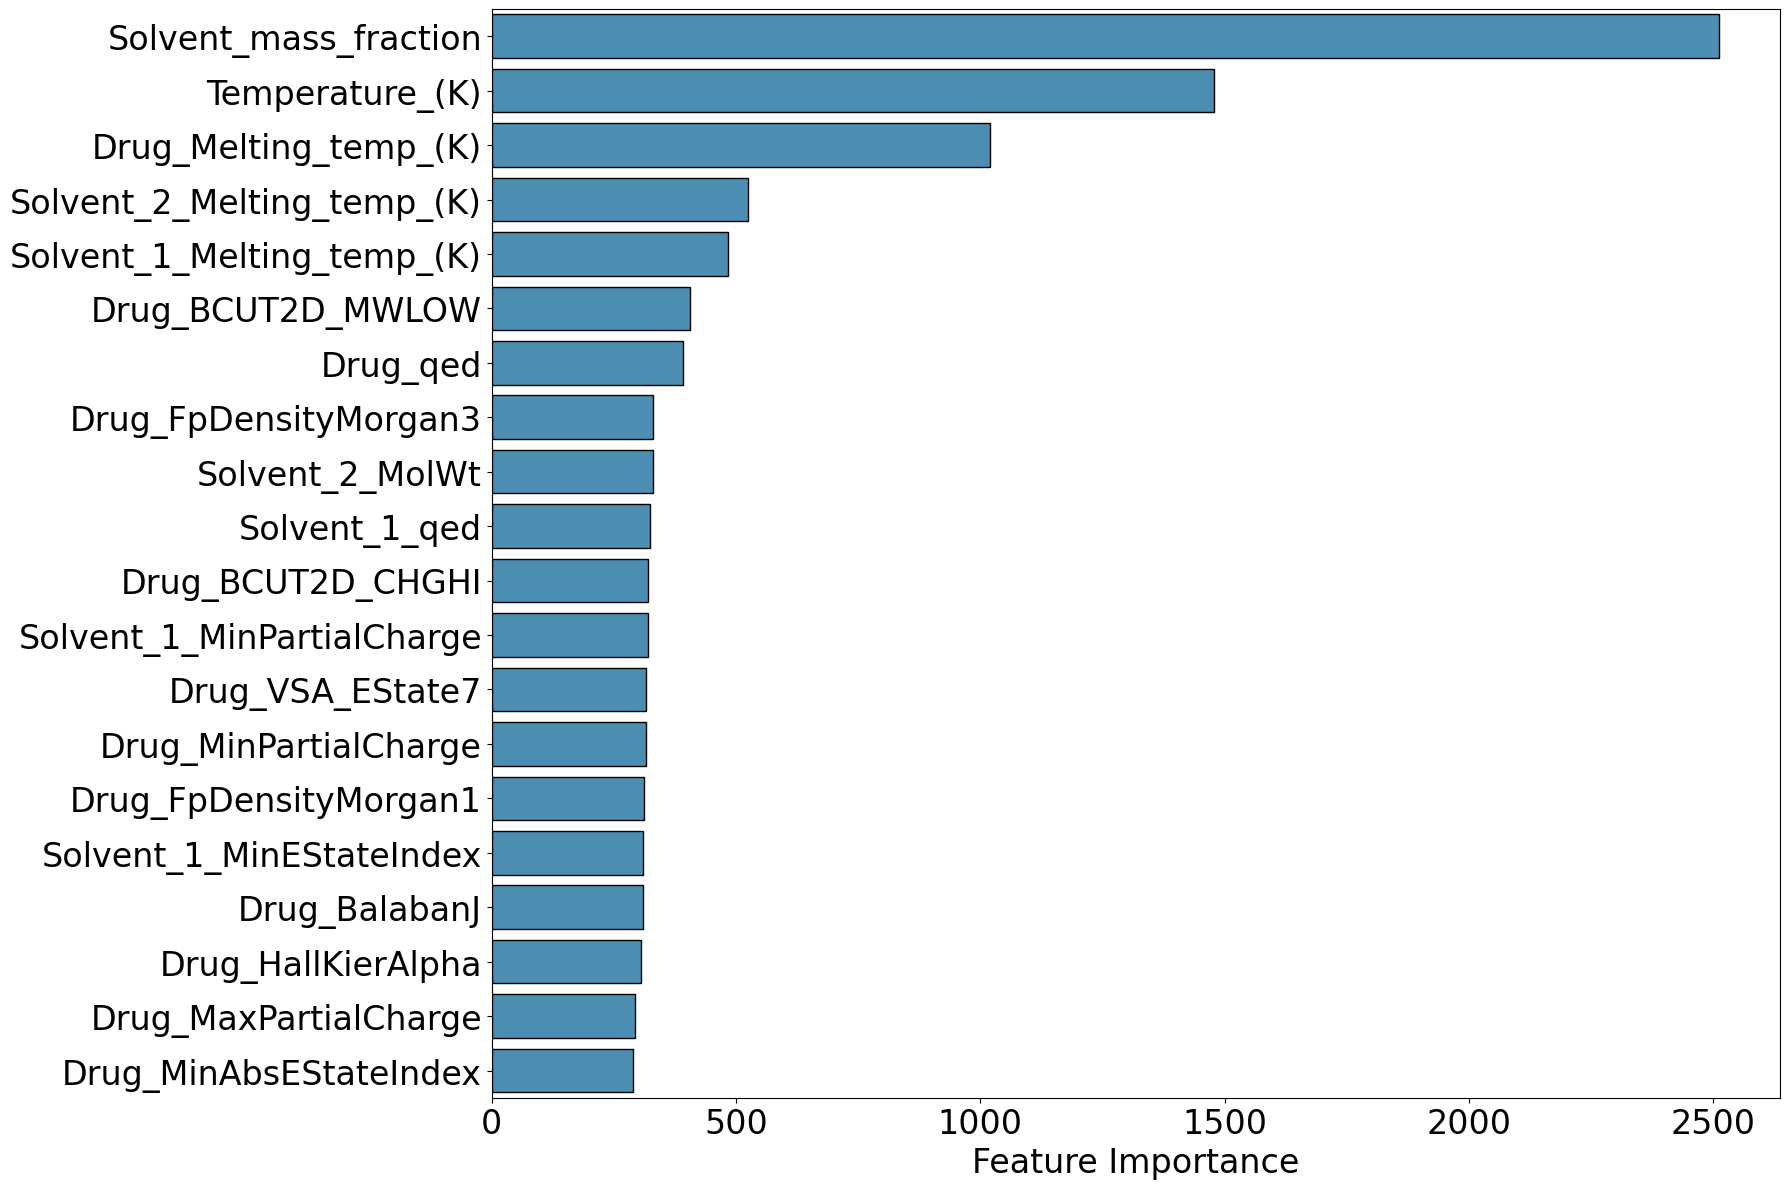

In [42]:
fig, ax1 = plt.subplots(figsize=(18, 12))
fontsize = 24

all_important_features = plot_feature_importance_lgb(model=best_model, ax=ax1, selected='', ann='', top_n=20, filter_drug_features=False)


ax1.set_xlabel('Feature Importance', fontsize=fontsize)  
ax1.set_ylabel('', fontsize=fontsize)  
ax1.tick_params(axis='x', labelsize=fontsize)  
ax1.tick_params(axis='y', labelsize=fontsize)  
plt.tight_layout()

fig.patch.set(facecolor='none')
fig.savefig('Figure_SI_top 20 features.png', dpi=300)

plt.show()

In [34]:
important_features

,Feature,Importance
2,Drug_Melting_temp_(K),1019
120,Drug_BCUT2D_MWLOW,406
114,Drug_qed,392
119,Drug_FpDensityMorgan3,330
121,Drug_BCUT2D_CHGHI,320
175,Drug_VSA_EState7,316
117,Drug_MinPartialCharge,316
118,Drug_FpDensityMorgan1,311
126,Drug_BalabanJ,309
127,Drug_HallKierAlpha,306


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


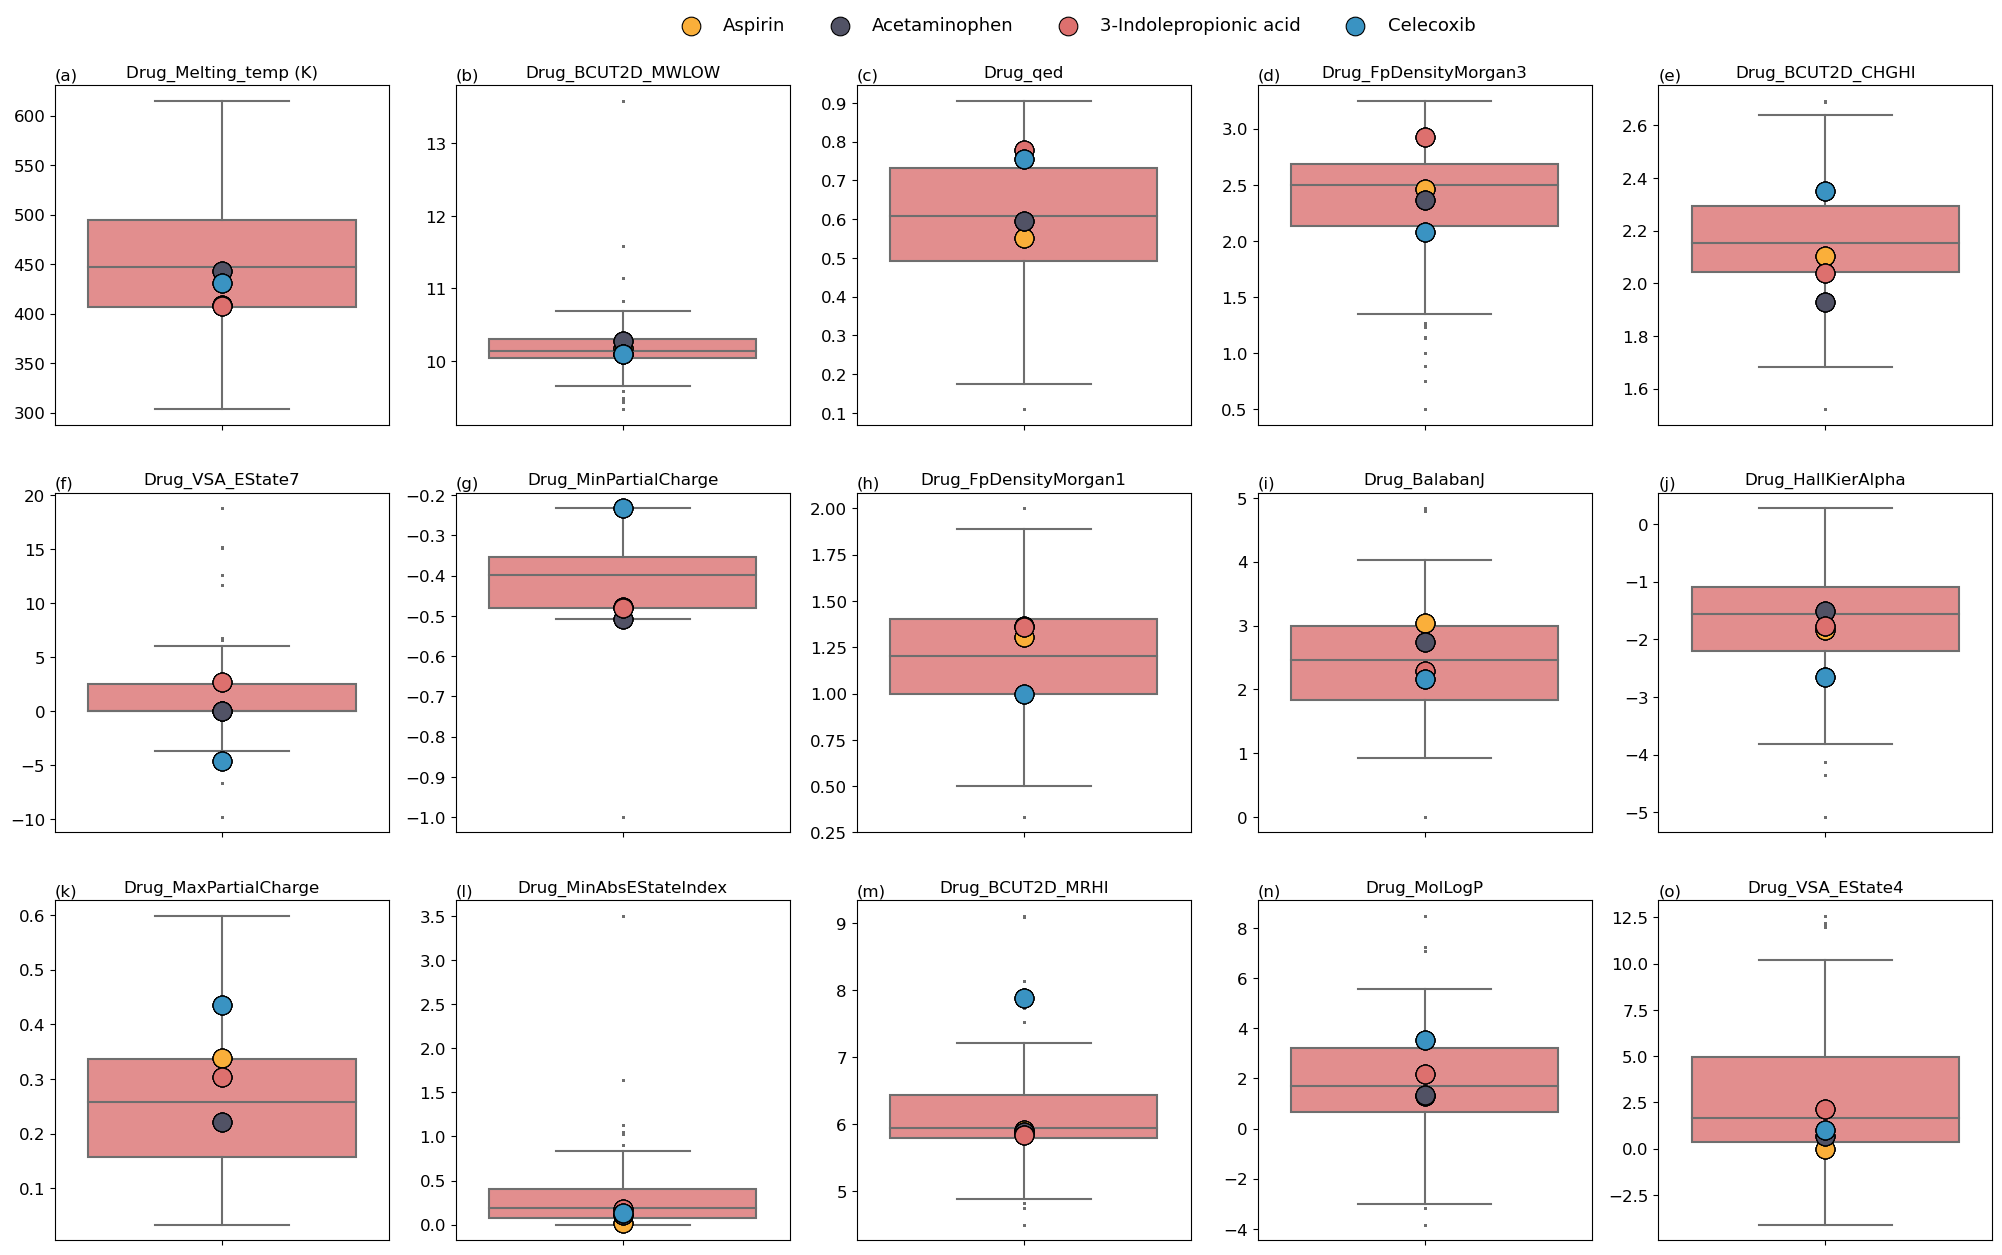

In [35]:

fig = plt.figure(figsize=(25, 15))  
gs = gridspec.GridSpec(3, 5, fig)  


for i, feature in enumerate(important_features['Feature']):
    row = i // 5  
    col = i % 5   
    ax = fig.add_subplot(gs[row, col])

    if (feature == 'Drug_Melting_temp_(K)'):
        feature = 'Drug_Melting_temp (K)'
    
    
    plot_distribution_with_labels_on_trend(
        ann=f'({chr(97+i)})',  
        prop=feature,
        ax=ax,
        show_legend=(i==14), legend_pos = (-3, 3.65), ncol = 4  
    )

plt.tight_layout()


fig.patch.set(facecolor='none')
fig.canvas.print_figure('Figure_SI_All_feture_distribution.png', dpi=600)

plt.show()




In [36]:
def print_summary_with_deviation_count():
    
    quantiles = literature_X.quantile([0.25, 0.75])
    
    
    unique_drugs = ['Acetaminophen', '3-Indolepropionic acid', 'Celecoxib','Aspirin']
    summary = []
    
    for feature in important_features['Feature']:
        
        if (feature == 'Drug_Melting_temp_(K)'):
            feature = 'Drug_Melting_temp (K)'
            
        Q1, Q3 = quantiles[feature].values
        for drug in unique_drugs:
            drug_data = lab_X[lab_X["Drug"] == drug]
            drug_feature_values = drug_data[feature]
            
           
            below_Q1 = drug_feature_values < Q1
            above_Q3 = drug_feature_values > Q3
            
            deviation = "deviates" if any(below_Q1) or any(above_Q3) else "does not deviate"
            
            summary.append([drug, feature, deviation])
    
    
    summary_df = pd.DataFrame(summary, columns=['Drug', 'Feature', 'Deviation'])
    summary_pivot = summary_df.pivot(index='Drug', columns='Feature', values='Deviation')
    
    
    deviation_counts = summary_df.groupby('Drug')['Deviation'].apply(lambda x: (x == "deviates").sum()).reset_index(name='Deviation Count')
    
    
    summary_with_counts = summary_pivot.merge(deviation_counts, left_on='Drug', right_on='Drug')
    summary_with_counts.set_index('Drug', inplace=True)
    
    
    columns_order = ['Deviation Count'] + [col for col in summary_with_counts if col != 'Deviation Count']
    summary_with_counts = summary_with_counts[columns_order]
    
    return summary_with_counts


summary_with_counts = print_summary_with_deviation_count()


In [37]:
summary_with_counts

,Deviation Count,Drug_BCUT2D_CHGHI,Drug_BCUT2D_MRHI,Drug_BCUT2D_MWLOW,Drug_BalabanJ,Drug_FpDensityMorgan1,Drug_FpDensityMorgan3,Drug_HallKierAlpha,Drug_MaxPartialCharge,Drug_Melting_temp (K),Drug_MinAbsEStateIndex,Drug_MinPartialCharge,Drug_MolLogP,Drug_VSA_EState4,Drug_VSA_EState7,Drug_qed
Drug,,,,,,,,,,,,,,,,
3-Indolepropionic acid,5,deviates,does not deviate,does not deviate,does not deviate,does not deviate,deviates,does not deviate,does not deviate,does not deviate,does not deviate,deviates,does not deviate,does not deviate,deviates,deviates
Acetaminophen,2,deviates,does not deviate,does not deviate,does not deviate,does not deviate,does not deviate,does not deviate,does not deviate,does not deviate,does not deviate,deviates,does not deviate,does not deviate,does not deviate,does not deviate
Aspirin,4,does not deviate,does not deviate,does not deviate,deviates,does not deviate,does not deviate,does not deviate,deviates,does not deviate,deviates,does not deviate,does not deviate,deviates,does not deviate,does not deviate
Celecoxib,9,deviates,deviates,does not deviate,does not deviate,does not deviate,deviates,deviates,deviates,does not deviate,does not deviate,deviates,deviates,does not deviate,deviates,deviates
